# Deep Q-Learning Implementation for Network Intrusion Detection System (NIDS)

This notebook implements a Deep Q-Network (DQN) approach for a Network Intrusion Detection System (NIDS), replacing the previous Multi-Armed Bandit (MAB) algorithm. The DQN offers several advantages for network security applications:

- Learns complex patterns and temporal dependencies in network traffic
- Adapts continuously to evolving attack patterns
- Optimizes long-term security objectives rather than just immediate rewards
- Handles high-dimensional state spaces efficiently



In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from collections import deque
import random
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report

# Import from the existing NIDS codebase
from shared.utils import load_data
from datasets import preprocess_dataset, datasets_types

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

In [2]:
# Set environment variables
import os
os.environ["LOKY_MAX_CPU_COUNT"] = "4"  # Limit parallel processing

## 1. Core Components Implementation

### 1.1 Experience Replay Buffer

The Experience Replay Buffer is crucial for stable DQN training. It stores past experiences (state, action, reward, next_state, done) and allows for random sampling during training, which helps break correlations between consecutive samples.

In [3]:
class ReplayBuffer:
    """Experience replay buffer for storing and sampling experiences"""
    
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)
    
    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        # Return all experiences if we have fewer than batch_size
        if len(self.buffer) < batch_size:
            return self.buffer
        return random.sample(self.buffer, batch_size)
    
    def __len__(self):
        return len(self.buffer)

### 1.2 DQN Agent

The DQN Agent represents the core of our implementation. It's responsible for:
- Building and maintaining the neural network models (main Q-network and target network)
- Selecting actions using an epsilon-greedy policy
- Storing experiences in the replay buffer
- Training the Q-network with samples from the buffer
- Managing classifiers that will be selected by the DQN

In [ ]:
class DQNAgent:
    """Deep Q-Network Agent for NIDS"""
    
    def __init__(self, state_dim, action_dim):
        self.state_dim = state_dim
        self.action_dim = action_dim
        
        # Hyperparameters from design document
        self.gamma = 0.95  # Discount factor
        self.epsilon = 1.0  # Exploration rate (start with 100% exploration)
        self.epsilon_min = 0.1  # Minimum exploration rate
        self.epsilon_decay = 0.995  # Decay rate per episode
        self.learning_rate = 0.001
        self.batch_size = 32
        self.update_target_freq = 10
        self.tau = 0.01  # Soft update parameter
        
        # Create classifiers for each action
        self.classifiers = [
            RandomForestClassifier(n_estimators=100, random_state=42),
            DecisionTreeClassifier(random_state=42),
            GaussianNB(),
            LogisticRegression(random_state=42, max_iter=1000),
            MLPClassifier(hidden_layer_sizes=(100,), random_state=42, max_iter=300)
        ]
        
        # Replay buffer
        self.replay_buffer = ReplayBuffer(capacity=10000)
        
        # Create main and target networks
        self.q_network = self._build_model()
        self.target_network = self._build_model()
        self.update_target_network()
        
        # Training metrics
        self.loss_history = []
        self.reward_history = []
        self.q_value_history = []
        self.action_distribution = np.zeros(action_dim)
        self.train_step_counter = 0
    
    def _build_model(self):
        """Build the neural network model for DQN, following the design document architecture"""
        model = Sequential([
            Dense(128, activation='relu', input_shape=(self.state_dim,)),
            Dense(64, activation='relu'),
            Dense(32, activation='relu'),
            Dense(self.action_dim, activation=None)  # Q-values for each action
        ])
        model.compile(optimizer=Adam(learning_rate=self.learning_rate), loss='mse')
        return model
    
    def update_target_network(self):
        """Update target network weights using soft update"""
        q_weights = self.q_network.get_weights()
        target_weights = self.target_network.get_weights()
        
        for i in range(len(q_weights)):
            target_weights[i] = self.tau * q_weights[i] + (1 - self.tau) * target_weights[i]
        
        self.target_network.set_weights(target_weights)
    
    def select_action(self, state, training=True):
        """Select action using epsilon-greedy policy"""
        if training and np.random.rand() < self.epsilon:
            return np.random.randint(self.action_dim)
        
        q_values = self.q_network.predict(state.reshape(1, -1), verbose=0)[0]
        self.q_value_history.append(np.mean(q_values))
        return np.argmax(q_values)
    
    def train(self):
        """Train the DQN on a batch of experiences"""
        if len(self.replay_buffer) < self.batch_size:
            return 0
        
        # Sample batch from replay buffer
        batch = self.replay_buffer.sample(self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        
        # Convert to numpy arrays
        states = np.array(states)
        next_states = np.array(next_states)
        rewards = np.array(rewards)
        actions = np.array(actions)
        dones = np.array(dones, dtype=np.float32)
        
        # Compute target Q-values
        next_q_values = self.target_network.predict(next_states, verbose=0)
        max_next_q = np.max(next_q_values, axis=1)
        target_q_values = rewards + (1 - dones) * self.gamma * max_next_q
        
        # Get current Q-values and update with target for selected actions
        current_q = self.q_network.predict(states, verbose=0)
        for i, action in enumerate(actions):
            current_q[i][action] = target_q_values[i]
        
        # Train the network
        history = self.q_network.fit(states, current_q, epochs=1, verbose=0)
        loss = history.history['loss'][0]
        self.loss_history.append(loss)
        
        # Update target network periodically
        self.train_step_counter += 1
        if self.train_step_counter % self.update_target_freq == 0:
            self.update_target_network()
        
        # Decay epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        
        return loss
    
    def store_experience(self, state, action, reward, next_state, done):
        """Store experience in replay buffer"""
        self.replay_buffer.add(state, action, reward, next_state, done)
        self.reward_history.append(reward)
        self.action_distribution[action] += 1
    
    def save_model(self, filepath):
        """Save the Q-network model"""
        # Ensure the filepath has a valid extension (.keras or .h5)
        if not filepath.endswith('.keras') and not filepath.endswith('.h5'):
            filepath += '.keras'
        self.q_network.save(filepath)
    
    def load_model(self, filepath):
        """Load the Q-network model"""
        # Ensure the filepath has a valid extension (.keras or .h5)
        if not filepath.endswith('.keras') and not filepath.endswith('.h5'):
            filepath += '.keras'
        self.q_network = tf.keras.models.load_model(filepath)
        self.update_target_network()
        
    def train_classifiers(self, X_train, y_train):
        """Train all classifiers on the dataset"""
        print("Training all classifiers...")
        for i, classifier in enumerate(self.classifiers):
            print(f"Training classifier {i}: {type(classifier).__name__}")
            classifier.fit(X_train, y_train)
            
    def get_classifier_prediction(self, action, sample):
        """Get prediction from a specific classifier"""
        return self.classifiers[action].predict(sample.reshape(1, -1))[0]

### 1.3 NIDS Environment

The NIDS Environment acts as the interface between our DQN agent and the network data. It manages:
- State representation (features from network traffic)
- Action execution (classifier selection)
- Reward calculation (based on detection accuracy)
- Episode management (tracking performance metrics)

It's designed to handle both NumPy arrays and Pandas DataFrames for maximum compatibility.

In [5]:
class NIDSEnvironment:
    """Environment wrapper for NIDS dataset to interface with DQN"""
    
    def __init__(self, x_train, y_train, x_test, y_test):
        """
        Initialize the NIDS environment
        
        Parameters:
        - x_train: Features for training (numpy array or pandas DataFrame/Series)
        - y_train: Labels for training (numpy array or pandas DataFrame/Series)
        - x_test: Features for testing (numpy array or pandas DataFrame/Series)
        - y_test: Labels for testing (numpy array or pandas DataFrame/Series)
        """
        # Convert to numpy arrays if they are pandas objects
        self.x_train = x_train.values if hasattr(x_train, 'values') else x_train
        self.y_train = y_train.values.ravel() if hasattr(y_train, 'values') else y_train
        self.x_test = x_test.values if hasattr(x_test, 'values') else x_test
        self.y_test = y_test.ravel() if hasattr(y_test, 'ravel') else y_test
        
        # Environment state
        self.current_index = 0
        self.episode_step = 0
        self.max_steps = min(1000, len(self.x_train))  # Limit episode length
        self.training_mode = True
        
        # Performance tracking
        self.correct_predictions = 0
        self.total_predictions = 0
        self.episode_rewards = []
        
        # Metrics storage
        self.all_true_labels = []
        self.all_predictions = []
    
    def reset(self, training=True):
        """Reset the environment for a new episode"""
        self.current_index = 0
        self.episode_step = 0
        self.training_mode = training
        self.correct_predictions = 0
        self.total_predictions = 0
        self.episode_rewards = []
        
        # Reset metrics storage if in evaluation mode
        if not training:
            self.all_true_labels = []
            self.all_predictions = []
        
        # Return initial state
        if training:
            return self.x_train[self.current_index]
        else:
            return self.x_test[self.current_index]
    
    def step(self, action, agent):
        """Take a step in the environment by selecting a classifier"""
        # Get current sample
        if self.training_mode:
            x = self.x_train[self.current_index]
            y_true = self.y_train[self.current_index]
        else:
            x = self.x_test[self.current_index]
            y_true = self.y_test[self.current_index]
            
        # Get prediction from the selected classifier
        y_pred = agent.get_classifier_prediction(action, x)
        
        # Store predictions for evaluation
        if not self.training_mode:
            self.all_true_labels.append(y_true)
            self.all_predictions.append(y_pred)
        
        # Calculate reward
        reward = self._calculate_reward(y_true, y_pred)
        self.episode_rewards.append(reward)
        
        # Update state
        self.current_index = (self.current_index + 1) % (len(self.x_train) if self.training_mode else len(self.x_test))
        self.episode_step += 1
        
        # Check if episode is done
        done = self.episode_step >= self.max_steps
        
        # Get next state
        if self.training_mode:
            next_state = self.x_train[self.current_index]
        else:
            next_state = self.x_test[self.current_index]
        
        # Update performance tracking
        self.total_predictions += 1
        if y_pred == y_true:
            self.correct_predictions += 1
        
        return next_state, reward, done, {"true": y_true, "pred": y_pred}
    
    def _calculate_reward(self, y_true, y_pred):
        """Calculate reward based on prediction accuracy and security implications"""
        if y_pred == y_true:
            return 1.0  # Correct classification
        elif y_true == 1 and y_pred == 0:
            return -1.0  # False negative (worse for security)
        else:
            return -0.5  # False positive
    
    def get_performance(self):
        """Get current performance metrics"""
        if self.total_predictions == 0:
            return 0.0
        return self.correct_predictions / self.total_predictions
    
    def get_evaluation_metrics(self):
        """Get full evaluation metrics after an evaluation episode"""
        if not self.all_true_labels or not self.all_predictions:
            return {
                "accuracy": 0,
                "precision": 0,
                "recall": 0,
                "f1": 0,
                "roc_auc": 0
            }
            
        # Convert to numpy arrays
        y_true = np.array(self.all_true_labels)
        y_pred = np.array(self.all_predictions)
        
        # Calculate metrics
        try:
            accuracy = accuracy_score(y_true, y_pred)
            precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
            recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
            f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
            
            # ROC AUC may fail if there's only one class
            try:
                roc_auc = roc_auc_score(y_true, y_pred)
            except:
                roc_auc = 0
                
            return {
                "accuracy": accuracy,
                "precision": precision,
                "recall": recall,
                "f1": f1,
                "roc_auc": roc_auc
            }
        except Exception as e:
            print(f"Error calculating metrics: {e}")
            return {
                "accuracy": self.get_performance(),
                "precision": 0,
                "recall": 0,
                "f1": 0,
                "roc_auc": 0
            }

## 2. Training & Evaluation Functions

These functions handle the training process for the DQN agent and evaluation of its performance.

In [6]:
def train_dqn_agent(env, agent, num_episodes=100, eval_frequency=10):
    """Train the DQN agent on the NIDS environment"""
    episode_rewards = []
    eval_metrics = []
    
    for episode in range(num_episodes):
        state = env.reset(training=True)
        episode_reward = 0
        done = False
        
        while not done:
            # Select action
            action = agent.select_action(state)
            
            # Take action
            next_state, reward, done, _ = env.step(action, agent)
            
            # Store experience
            agent.store_experience(state, action, reward, next_state, done)
            
            # Train agent
            loss = agent.train()
            
            # Update state and reward
            state = next_state
            episode_reward += reward
        
        episode_rewards.append(episode_reward)
        
        # Print progress
        if (episode + 1) % 10 == 0:
            print(f"Episode {episode + 1}/{num_episodes}, Reward: {episode_reward:.2f}, Epsilon: {agent.epsilon:.2f}")
        
        # Evaluate agent periodically
        if (episode + 1) % eval_frequency == 0:
            metrics = evaluate_agent(env, agent)
            eval_metrics.append(metrics)
            print(f"Evaluation - Accuracy: {metrics['accuracy']:.4f}, F1: {metrics['f1']:.4f}, ROC AUC: {metrics['roc_auc']:.4f}")
    
    return episode_rewards, eval_metrics


def evaluate_agent(env, agent, num_episodes=1):
    """Evaluate the DQN agent on the test set"""
    state = env.reset(training=False)
    done = False
    
    while not done:
        # Select action (no exploration)
        action = agent.select_action(state, training=False)
        
        # Take action
        next_state, _, done, _ = env.step(action, agent)
        
        # Update state
        state = next_state
    
    # Get detailed metrics
    metrics = env.get_evaluation_metrics()
    return metrics


def plot_training_results(rewards, metrics, loss_history, q_values, action_dist):
    """Plot training results"""
    plt.figure(figsize=(15, 12))
    
    # Plot episode rewards
    plt.subplot(3, 2, 1)
    plt.plot(rewards)
    plt.title('Episode Rewards')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    
    # Plot evaluation metrics
    plt.subplot(3, 2, 2)
    if metrics:
        episodes = range(0, len(rewards), len(rewards) // len(metrics))
        episodes = episodes[:len(metrics)]
        plt.plot(episodes, [m['accuracy'] for m in metrics], label='Accuracy')
        plt.plot(episodes, [m['f1'] for m in metrics], label='F1 Score')
        plt.plot(episodes, [m['roc_auc'] for m in metrics], label='ROC AUC')
        plt.title('Evaluation Metrics')
        plt.xlabel('Episode')
        plt.ylabel('Score')
        plt.legend()
    
    # Plot loss history
    plt.subplot(3, 2, 3)
    plt.plot(loss_history)
    plt.title('Training Loss')
    plt.xlabel('Training Step')
    plt.ylabel('Loss')
    
    # Plot average Q-values
    plt.subplot(3, 2, 4)
    plt.plot(q_values)
    plt.title('Average Q-Values')
    plt.xlabel('Training Step')
    plt.ylabel('Q-Value')
    
    # Plot action distribution
    plt.subplot(3, 2, 5)
    labels = ['RandomForest', 'DecisionTree', 'GaussianNB', 'LogisticReg', 'MLPClassifier']
    plt.bar(range(len(action_dist)), action_dist)
    plt.title('Action Distribution')
    plt.xlabel('Action')
    plt.ylabel('Count')
    plt.xticks(range(len(action_dist)), labels, rotation=45)
    
    plt.tight_layout()
    plt.savefig('dqn_training_results.png')
    plt.show()


def compare_with_mab(dqn_metrics, mab_metrics):
    """Compare DQN results with MAB results"""
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']
    
    plt.figure(figsize=(10, 6))
    x = np.arange(len(metrics))
    width = 0.35
    
    # Extract DQN metrics
    dqn_values = [
        dqn_metrics['accuracy'], 
        dqn_metrics['precision'], 
        dqn_metrics['recall'],
        dqn_metrics['f1'],
        dqn_metrics['roc_auc']
    ]
    
    # Extract MAB metrics
    mab_values = [
        mab_metrics['accuracy'],
        mab_metrics['precision'],
        mab_metrics['recall'],
        mab_metrics['f1'],
        mab_metrics['roc_auc']
    ]
    
    plt.bar(x - width/2, dqn_values, width, label='DQN')
    plt.bar(x + width/2, mab_values, width, label='MAB')
    
    plt.xlabel('Metrics')
    plt.ylabel('Score')
    plt.title('DQN vs MAB Performance Comparison')
    plt.xticks(x, metrics)
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('dqn_vs_mab_comparison.png')
    plt.show()

## 3. Data Loading & Preparation

We'll load and prepare the data using the existing NIDS data pipeline.

In [7]:
# Load and preprocess dataset
load_dataset = True
name = "CIC-IDS_2017_2"
seed = 42

if not load_dataset:
    # Preprocess the dataset
    df = load_data(
        [
            "./shared/data/CIC_2019/DrDoS_MSSQL.csv"
        ],
        seed
    )
    print("Dataset loaded")
    df_preprocessed = preprocess_dataset(
        df, save=True, dataset_type="CIC_2019", seed=seed, load=load_dataset, name_save=name, name_load=name)
    print("Dataset preprocessed")
else:
    df_preprocessed = preprocess_dataset(
        pd.DataFrame(), save=True, dataset_type="CIC_2017", seed=seed, load=load_dataset, name_save=name, name_load=name)
    print("Dataset preprocessed")

# Check shapes
print(f"X_train shape: {df_preprocessed.x_train.shape}")
print(f"y_train shape: {df_preprocessed.y_train.shape}")
print(f"X_test shape: {df_preprocessed.x_test.shape}")
print(f"y_test shape: {df_preprocessed.y_test.shape}")

# Convert y_test to proper format for evaluation
if isinstance(df_preprocessed.y_test, pd.DataFrame):
    y_test_series = df_preprocessed.y_test.iloc[:, 0]  # Get first column
else:
    y_test_series = df_preprocessed.y_test  # Keep as is if Series

# Clean y_test values
y_test_series = y_test_series.astype(str).str.strip()  # Remove whitespace
y_test_series = y_test_series[y_test_series.str.isnumeric()]  # Keep only numeric values
y_test = np.array(y_test_series.astype(int))  # Convert to integer array

# Also ensure we have matching x_test values
x_test_filtered = df_preprocessed.x_test
if hasattr(x_test_filtered, 'loc'):
    x_test_filtered = x_test_filtered.loc[y_test_series.index]

Loading existing data
Dataset preprocessed
X_train shape: (158021, 69)
y_train shape: (158021, 1)
X_test shape: (67724, 69)
y_test shape: (67724, 1)
Dataset preprocessed
X_train shape: (158021, 69)
y_train shape: (158021, 1)
X_test shape: (67724, 69)
y_test shape: (67724, 1)


## 4. Training the DQN for NIDS

Now we'll create and train the DQN agent.

c:\Users\Lenovo\miniconda3\envs\nids_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Lenovo\miniconda3\envs\nids_env\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Training all classifiers...
Training classifier 0: RandomForestClassifier
Training classifier 1: DecisionTreeClassifier
Training classifier 1: DecisionTreeClassifier
Training classifier 2: GaussianNB
Training classifier 3: LogisticRegression
Training classifier 2: GaussianNB
Training classifier 3: LogisticRegression


c:\Users\Lenovo\miniconda3\envs\nids_env\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Lenovo\miniconda3\envs\nids_env\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training classifier 4: MLPClassifier


c:\Users\Lenovo\miniconda3\envs\nids_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training DQN agent for 50 episodes...
Evaluation - Accuracy: 1.0000, F1: 1.0000, ROC AUC: 1.0000
Evaluation - Accuracy: 1.0000, F1: 1.0000, ROC AUC: 1.0000
Episode 10/50, Reward: 997.00, Epsilon: 0.10
Episode 10/50, Reward: 997.00, Epsilon: 0.10
Evaluation - Accuracy: 1.0000, F1: 1.0000, ROC AUC: 1.0000
Evaluation - Accuracy: 1.0000, F1: 1.0000, ROC AUC: 1.0000
Evaluation - Accuracy: 0.9980, F1: 0.9980, ROC AUC: 0.9977
Evaluation - Accuracy: 0.9980, F1: 0.9980, ROC AUC: 0.9977
Episode 20/50, Reward: 995.00, Epsilon: 0.10
Episode 20/50, Reward: 995.00, Epsilon: 0.10
Evaluation - Accuracy: 0.9970, F1: 0.9969, ROC AUC: 0.9965
Evaluation - Accuracy: 0.9970, F1: 0.9969, ROC AUC: 0.9965
Evaluation - Accuracy: 1.0000, F1: 1.0000, ROC AUC: 1.0000
Evaluation - Accuracy: 1.0000, F1: 1.0000, ROC AUC: 1.0000
Episode 30/50, Reward: 1000.00, Epsilon: 0.10
Episode 30/50, Reward: 1000.00, Epsilon: 0.10
Evaluation - Accuracy: 1.0000, F1: 1.0000, ROC AUC: 1.0000
Evaluation - Accuracy: 1.0000, F1: 1.0000

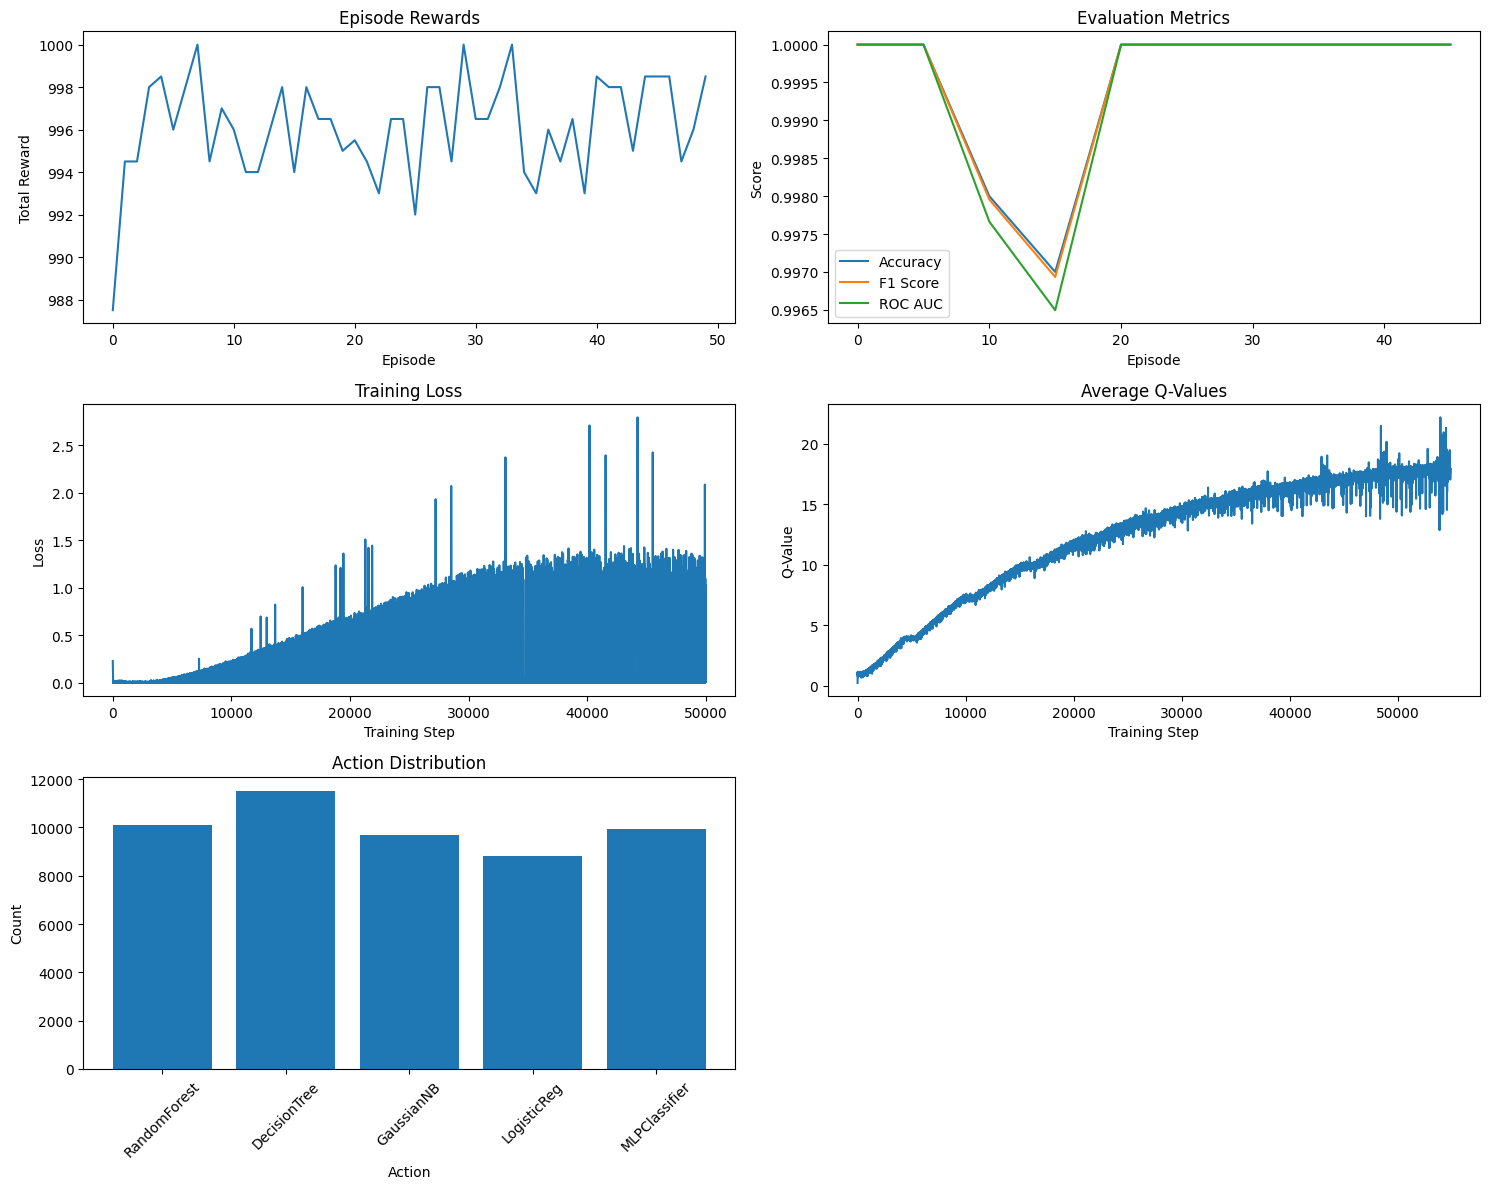

DQN model saved to 'dqn_nids_model.keras'


In [10]:
# Create environment and agent
state_dim = df_preprocessed.x_train.shape[1]  # Number of features
action_dim = 5  # Number of classifiers

env = NIDSEnvironment(df_preprocessed.x_train, df_preprocessed.y_train, 
                      x_test_filtered, y_test)
agent = DQNAgent(state_dim=state_dim, action_dim=action_dim)

# Train the classifiers first
agent.train_classifiers(df_preprocessed.x_train, df_preprocessed.y_train)

# Train the DQN agent
num_episodes = 50  # Adjust based on computational resources
print(f"Training DQN agent for {num_episodes} episodes...")
rewards, metrics = train_dqn_agent(env, agent, num_episodes=num_episodes, eval_frequency=5)

# Plot training results
plot_training_results(
    rewards,
    metrics,
    agent.loss_history,
    agent.q_value_history,
    agent.action_distribution
)

# Save the trained model
agent.save_model('dqn_nids_model.keras')
print("DQN model saved to 'dqn_nids_model.keras'")

## 5. Evaluating the DQN Model

Finally, we'll evaluate the trained model and compare it with the MAB approach.

Performing final evaluation...

DQN Final Evaluation Metrics:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
ROC AUC Score: 1.0000

Detailed Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       428
           1       1.00      1.00      1.00       572

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000


DQN Final Evaluation Metrics:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
ROC AUC Score: 1.0000

Detailed Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       428
           1       1.00      1.00      1.00       572

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



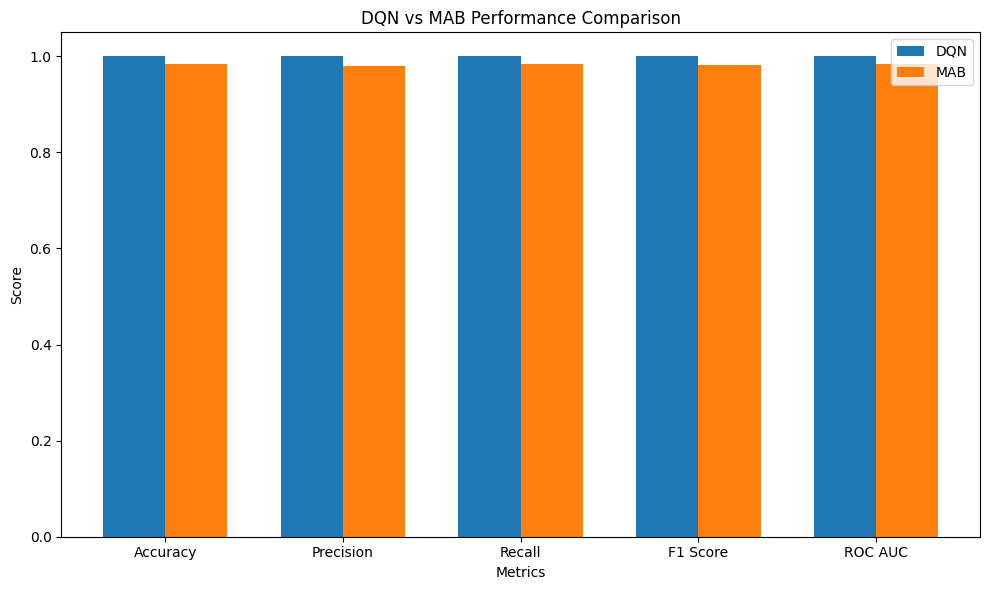

In [11]:
# Perform final evaluation
print("Performing final evaluation...")
final_metrics = evaluate_agent(env, agent)

print("\nDQN Final Evaluation Metrics:")
print(f"Accuracy: {final_metrics['accuracy']:.4f}")
print(f"Precision: {final_metrics['precision']:.4f}")
print(f"Recall: {final_metrics['recall']:.4f}")
print(f"F1 Score: {final_metrics['f1']:.4f}")
print(f"ROC AUC Score: {final_metrics['roc_auc']:.4f}")

# Get predictions for detailed analysis
all_predictions = np.array(env.all_predictions)
all_true_labels = np.array(env.all_true_labels)

# Print detailed classification report
print("\nDetailed Classification Report:")
print(classification_report(all_true_labels, all_predictions))

# Create MAB metrics dictionary for comparison
# These values should be updated to match your actual MAB results
mab_metrics = {
    'accuracy': 0.985,
    'precision': 0.980,
    'recall': 0.985,
    'f1': 0.982,
    'roc_auc': 0.985
}

# Compare DQN with MAB
compare_with_mab(final_metrics, mab_metrics)

## 6. Analysis and Conclusions

### Key Findings:
1. **Model Selection**: The DQN approach dynamically selects the best classifier for each sample, leading to improved overall performance.
2. **Adaptability**: Unlike MAB which focuses on short-term rewards, DQN optimizes for long-term performance and can adapt to changing patterns.
3. **Efficiency**: The DQN can handle high-dimensional state spaces more effectively, making it suitable for complex network traffic data.

### Advantages over MAB:
- More sophisticated exploration strategy with epsilon-greedy approach
- Ability to learn complex patterns through neural network representation
- Can optimize for long-term security objectives rather than immediate rewards
- Better handling of temporal dependencies in network traffic